# Oxford Pets

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

import matplotlib.pyplot as plt
import numpy as np

## Load the dataset

In [ ]:
imagenet_means = [0.485, 0.456, 0.406]
imagenet_stdev = [0.229, 0.224, 0.225]

p_color_jitter = 0.2
p_random_crop = 1
p_grayscale = 0.1
p_horizontal_flip = 0.5

img_dim_sq = 224 # image size 224x224

transform = T.Compose([
    T.Resize(img_dim_sq),      # Resize imgs to have a min size of 256
    T.CenterCrop(img_dim_sq),  # Make image square 224x224 from the center
    #Adding data augmentation
    T.RandomApply(nn.ModuleList([
        T.ColorJitter(brightness=(0.5, 1), contrast=(0.5, 1), saturation=(0.5, 1))
    ]), p=p_color_jitter),
    T.RandomApply(nn.ModuleList([
        T.RandomCrop(size=(img_dim_sq, img_dim_sq))
    ]), p=p_random_crop),
    T.RandomGrayscale(p=p_grayscale),
    T.RandomHorizontalFlip(p=p_horizontal_flip),

    # To Tensor and Normalize
    T.ToTensor(),       # turn imgs from (HxWxC) in [0,255], to FloatTensor (CxHxW) in [0.0,1.0]
    T.Normalize(        # normalize tensors to the range [-1.0,1.0]
        imagenet_means, imagenet_stdev
    )
])


batch_size = 64

train_dataset = OxfordIIITPet(root='./dataset/train', split='trainval', download=True, transform=transform)
test_dataset = OxfordIIITPet(root='./dataset/test', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=2)

class_names = train_dataset.classes
print(class_names)

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


## Visualize the dataset

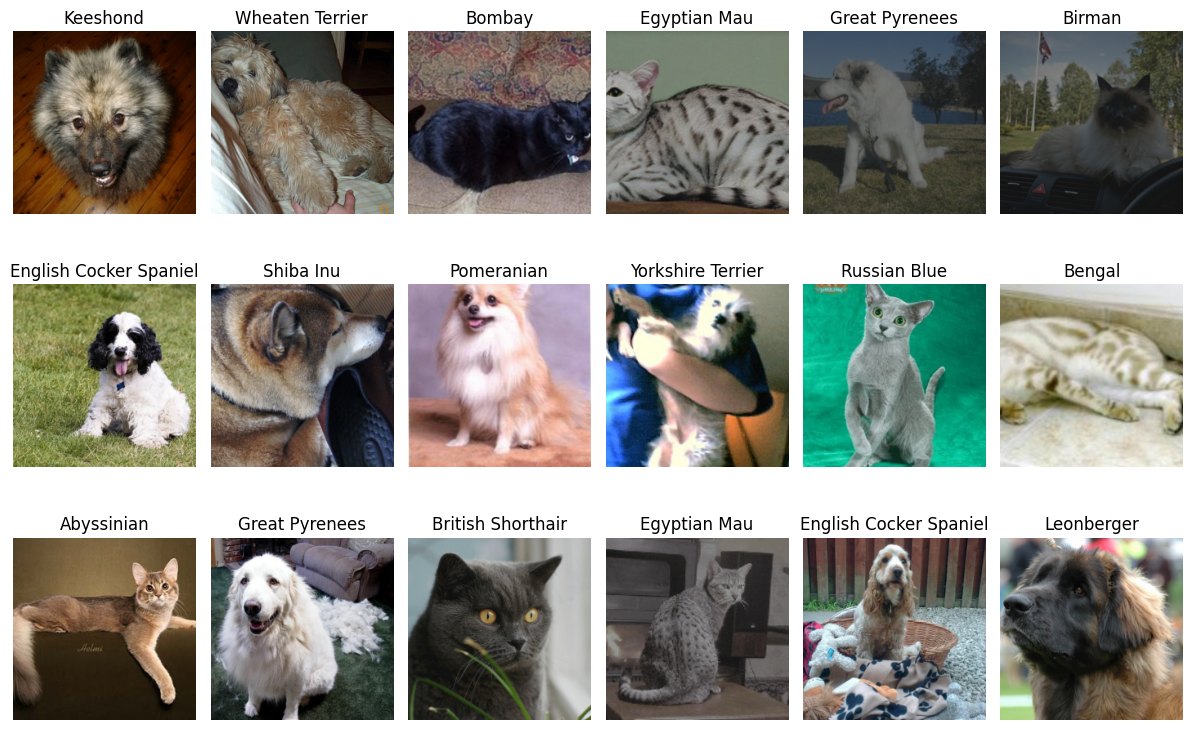

In [ ]:
def show_images(images, labels, predictions=None, rows=3, cols=6):
    images = images[0:rows*cols]
    labels = labels[0:rows*cols]
    if predictions is not None:
        predictions = predictions[0:rows*cols]
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for idx, ax in enumerate(axes.ravel()):
        img = images[idx]
        label = labels[idx].item()
        if predictions is None:
            ax.set_title(f"{class_names[label]}")
        else:
            pred = predictions[idx].item()
            ax.set_title(f"{class_names[label]}\n{class_names[pred]}")
        img = img.numpy().transpose((1, 2, 0))  # (C, W, H) -> (W, H, C)
        mean = np.array(imagenet_means)
        std = np.array(imagenet_stdev)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_images(images, labels)

## Load pre-trained ResNet

In [ ]:
num_classes = len(class_names)
pretrained_config = torchvision.models.ResNet50_Weights.DEFAULT
print(f"Pre-trained configuration: {pretrained_config}")
model = torchvision.models.resnet50(weights=pretrained_config)
print(model)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

Pre-trained configuration: ResNet50_Weights.IMAGENET1K_V2
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
  

## Fine-tune the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
num_epochs = 10

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

In [ ]:
model.train()
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 1.5080
Epoch [2/10], Loss: 0.8022
Epoch [3/10], Loss: 0.3667
Epoch [4/10], Loss: 0.3365
Epoch [5/10], Loss: 0.3223
Epoch [6/10], Loss: 0.2438
Epoch [7/10], Loss: 0.2442
Epoch [8/10], Loss: 0.1538
Epoch [9/10], Loss: 0.1762
Epoch [10/10], Loss: 0.1305


## Perform an evaluation

In [ ]:
# source https://saturncloud.io/blog/how-to-get-topk-accuracy-in-semantic-segmentation-using-pytorch/
def top_k_accuracy(pred, target, k=1):
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred_topk = pred.topk(k, dim=1)
        pred_topk = pred_topk.view(batch_size, -1)
        target = target.view(batch_size, -1)
        correct = pred_topk.eq(target)
        return correct.sum().item() / target.numel()


model.eval()
with torch.no_grad():
    total = 0
    normal_accuracy = 0.0
    accuracy_top5 = 0.0
    accuracy_top4 = 0.0
    accuracy_top3 = 0.0
    accuracy_top2 = 0.0
    accuracy_top1 = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # Accuracy@5 (or top5) - doing top 4 to 2 for fun
        accuracy_top5 += top_k_accuracy(outputs, labels, k=5) * images.size(0)
        accuracy_top4 += top_k_accuracy(outputs, labels, k=4) * images.size(0)
        accuracy_top3 += top_k_accuracy(outputs, labels, k=3) * images.size(0)
        accuracy_top2 += top_k_accuracy(outputs, labels, k=2) * images.size(0)
        accuracy_top1 += top_k_accuracy(outputs, labels, k=1) * images.size(0)


        # Normal Accuracy with arg max (must be equal to top1) -- se deja por debug del "accuracy_top1"
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(dim=0)
        normal_accuracy += (predicted == labels).sum().item()

    normal_accuracy /= total
    accuracy_top5 /= total
    accuracy_top4 /= total
    accuracy_top3 /= total
    accuracy_top2 /= total
    accuracy_top1 /= total

    print(f"Accuracy: {100 * normal_accuracy:.2f}%")
    print("\nAccuracy Top-K: \n")
    print(f"Accuracy Top 1: {100 * accuracy_top1:.2f}% | (must be equal to normal accuracy)")
    print(f"Accuracy Top 2: {100 * accuracy_top2:.2f}%")
    print(f"Accuracy Top 3: {100 * accuracy_top3:.2f}%")
    print(f"Accuracy Top 4: {100 * accuracy_top4:.2f}%")
    print(f"Accuracy Top 5: {100 * accuracy_top5:.2f}%")







Accuracy: 90.19%

Accuracy Top-K: 

Accuracy Top 1: 90.19% | (must be equal to normal accuracy)
Accuracy Top 2: 96.22%
Accuracy Top 3: 98.44%
Accuracy Top 4: 99.07%
Accuracy Top 5: 99.42%


## Visualize results

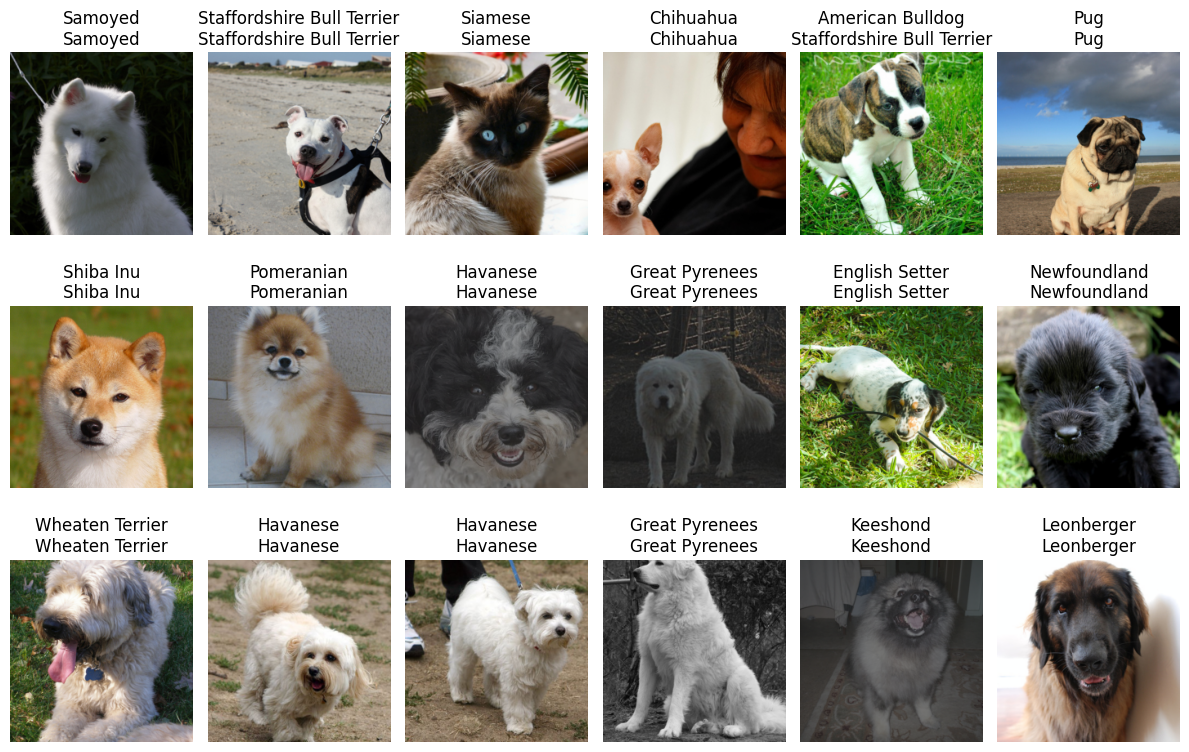

In [ ]:
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
predicted = torch.argmax(outputs, dim=1).cpu()
show_images(images, labels, predicted)

# TODOs:

1. [X] Compute Accuracy@5 and compare it with Accuracy.
2. [X] Add data augmentation, such as horizontal and vertical flip, color jitter, and grayscale.
3. [ ] [Optional] Gradually unfreeze layers of the ResNet to implement multi-phased fine-tuning.